In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img


from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, UpSampling2D, Input


# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#            print(os.path.join(dirname, filename))
# os.listdir('/kaggle/input/')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-18 07:01:58.839013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 07:01:58.839132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 07:01:58.976215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


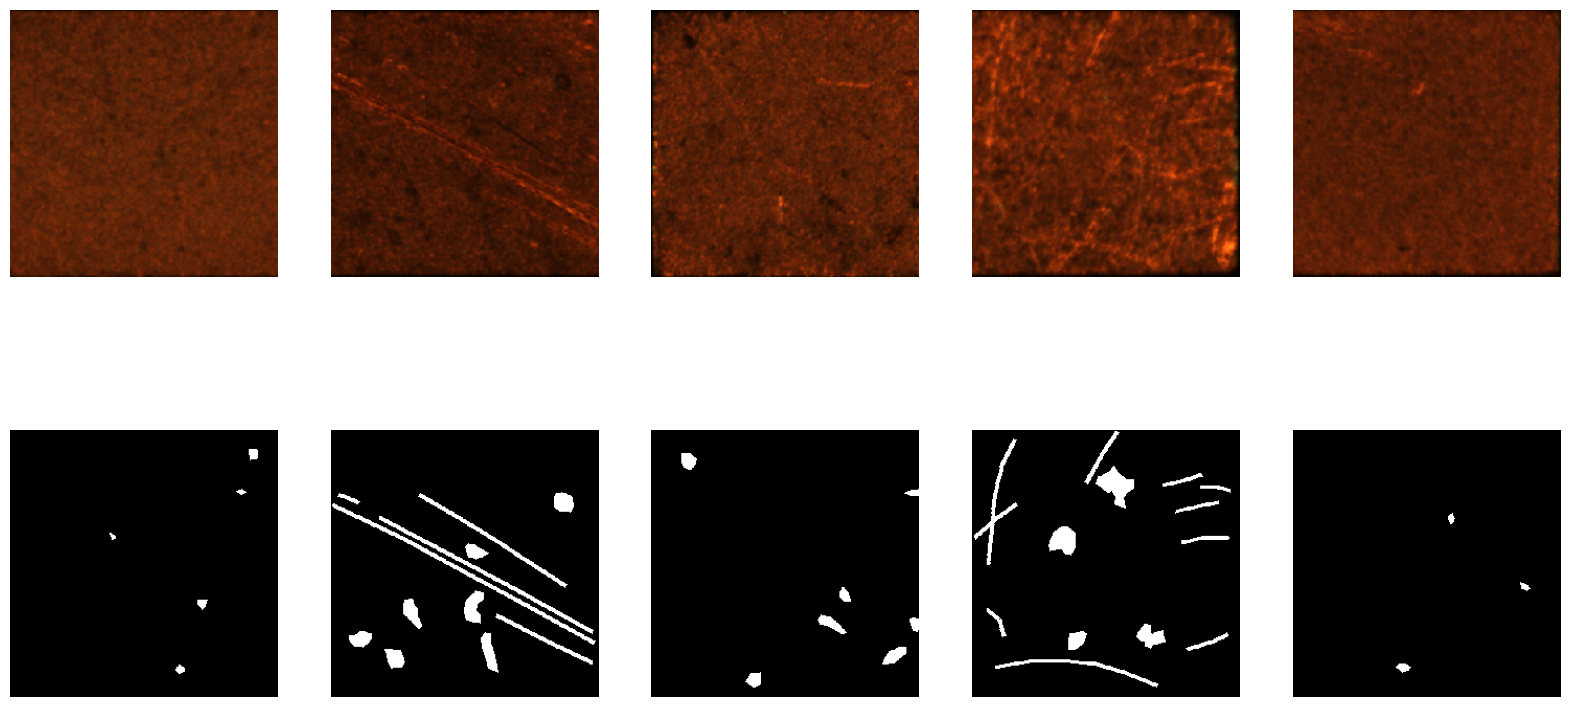

In [2]:
# Function to load images and masks with contrast enhancement:
def load_images(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        if img_name.endswith('.bmp'):
            img_path = os.path.join(image_dir, img_name)
            mask_name = img_name.replace('.bmp', '.png')
            mask_path = os.path.join(mask_dir, mask_name)
            if os.path.exists(mask_path):
                img = img_to_array(load_img(img_path, target_size=target_size, color_mode='rgb'))
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, target_size)
                mask = cv2.equalizeHist(mask)
                mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension
                images.append(img)
                masks.append(mask)
    return np.array(images), np.array(masks)

# Define directories (ensure these paths are correct)
image_dir = "/kaggle/input/Heat_Sink_Surface_Defect_Dataset/images"  # Replace with your image directory
mask_dir = "/kaggle/input/Heat_Sink_Surface_Defect_Dataset/labels"    # Replace with your mask directory

# Load images and masks
images, masks = load_images(image_dir, mask_dir)

# Normalize images
images = images / 255.0
masks = masks / 255.0

# Ensure masks are binary
masks[masks > 0.5] = 1
masks[masks <= 0.5] = 0

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)


# Function to display images and masks
def display_samples(images, masks, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Display samples
display_samples(X_train, y_train)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def resnet50_segmentation_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    
    # Decoder part
    x = base_model.output
    
    # Ensure the feature map size is upsampled to match the input size
    x = UpSampling2D((2, 2))(x)  # From (8, 8) to (16, 16)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    
    x = UpSampling2D((2, 2))(x)  # From (16, 16) to (32, 32)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    x = UpSampling2D((2, 2))(x)  # From (32, 32) to (64, 64)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    x = UpSampling2D((2, 2))(x)  # From (64, 64) to (128, 128)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    x = UpSampling2D((2, 2))(x)  # From (128, 128) to (256, 256)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs, x)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = resnet50_segmentation_model()
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 34,592,641 (131.96 MB)

 Trainable params: 34,539,521 (131.76 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [4]:
# Set up callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True)
]

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size=8, 
                    epochs=50, 
                    callbacks=callbacks)

Epoch 1/50


I0000 00:00:1718694243.157496      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 165s 864ms/step - accuracy: 0.9649 - loss: 0.3421 - val_accuracy: 0.9760 - val_loss: 0.3516
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - accuracy: 0.9731 - loss: 0.0945 - val_accuracy: 0.9760 - val_loss: 0.1435
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.9742 - loss: 0.0850 - val_accuracy: 0.9760 - val_loss: 0.1351
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.9755 - loss: 0.0739 - val_accuracy: 0.9760 - val_loss: 0.1865
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - accuracy: 0.9767 - loss: 0.0671 - val_accuracy: 0.9760 - val_loss: 0.1449
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 209ms/step - accuracy: 0.9790 - loss: 0.0579 - val_accuracy: 0.9760 - val_loss: 0.1291
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - accuracy: 0.9790 - loss: 0.0539 - val_accuracy: 0.9760 - val_loss: 0.1596
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - accuracy: 0.9801 - loss: 0.0493 - val_accuracy: 0.97

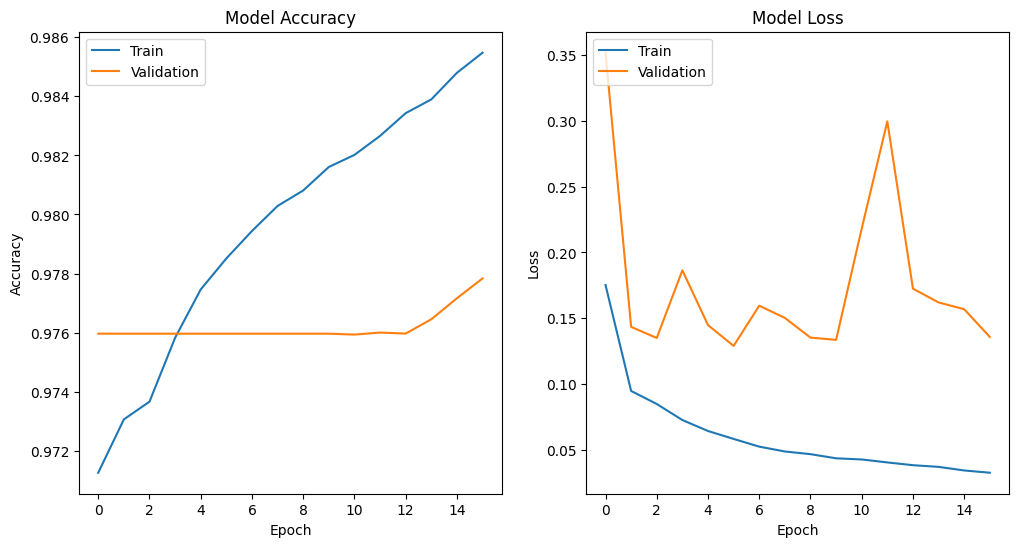

4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9773 - loss: 0.1222
Test Loss: 0.1315755695104599
Test Accuracy: 0.9762625694274902


In [5]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
Measurement Validation Measurement
Accuracy: 0.9778
Precision: 0.6180
Recall: 0.2037
F1 score: 0.3064
IoU: 0.1809


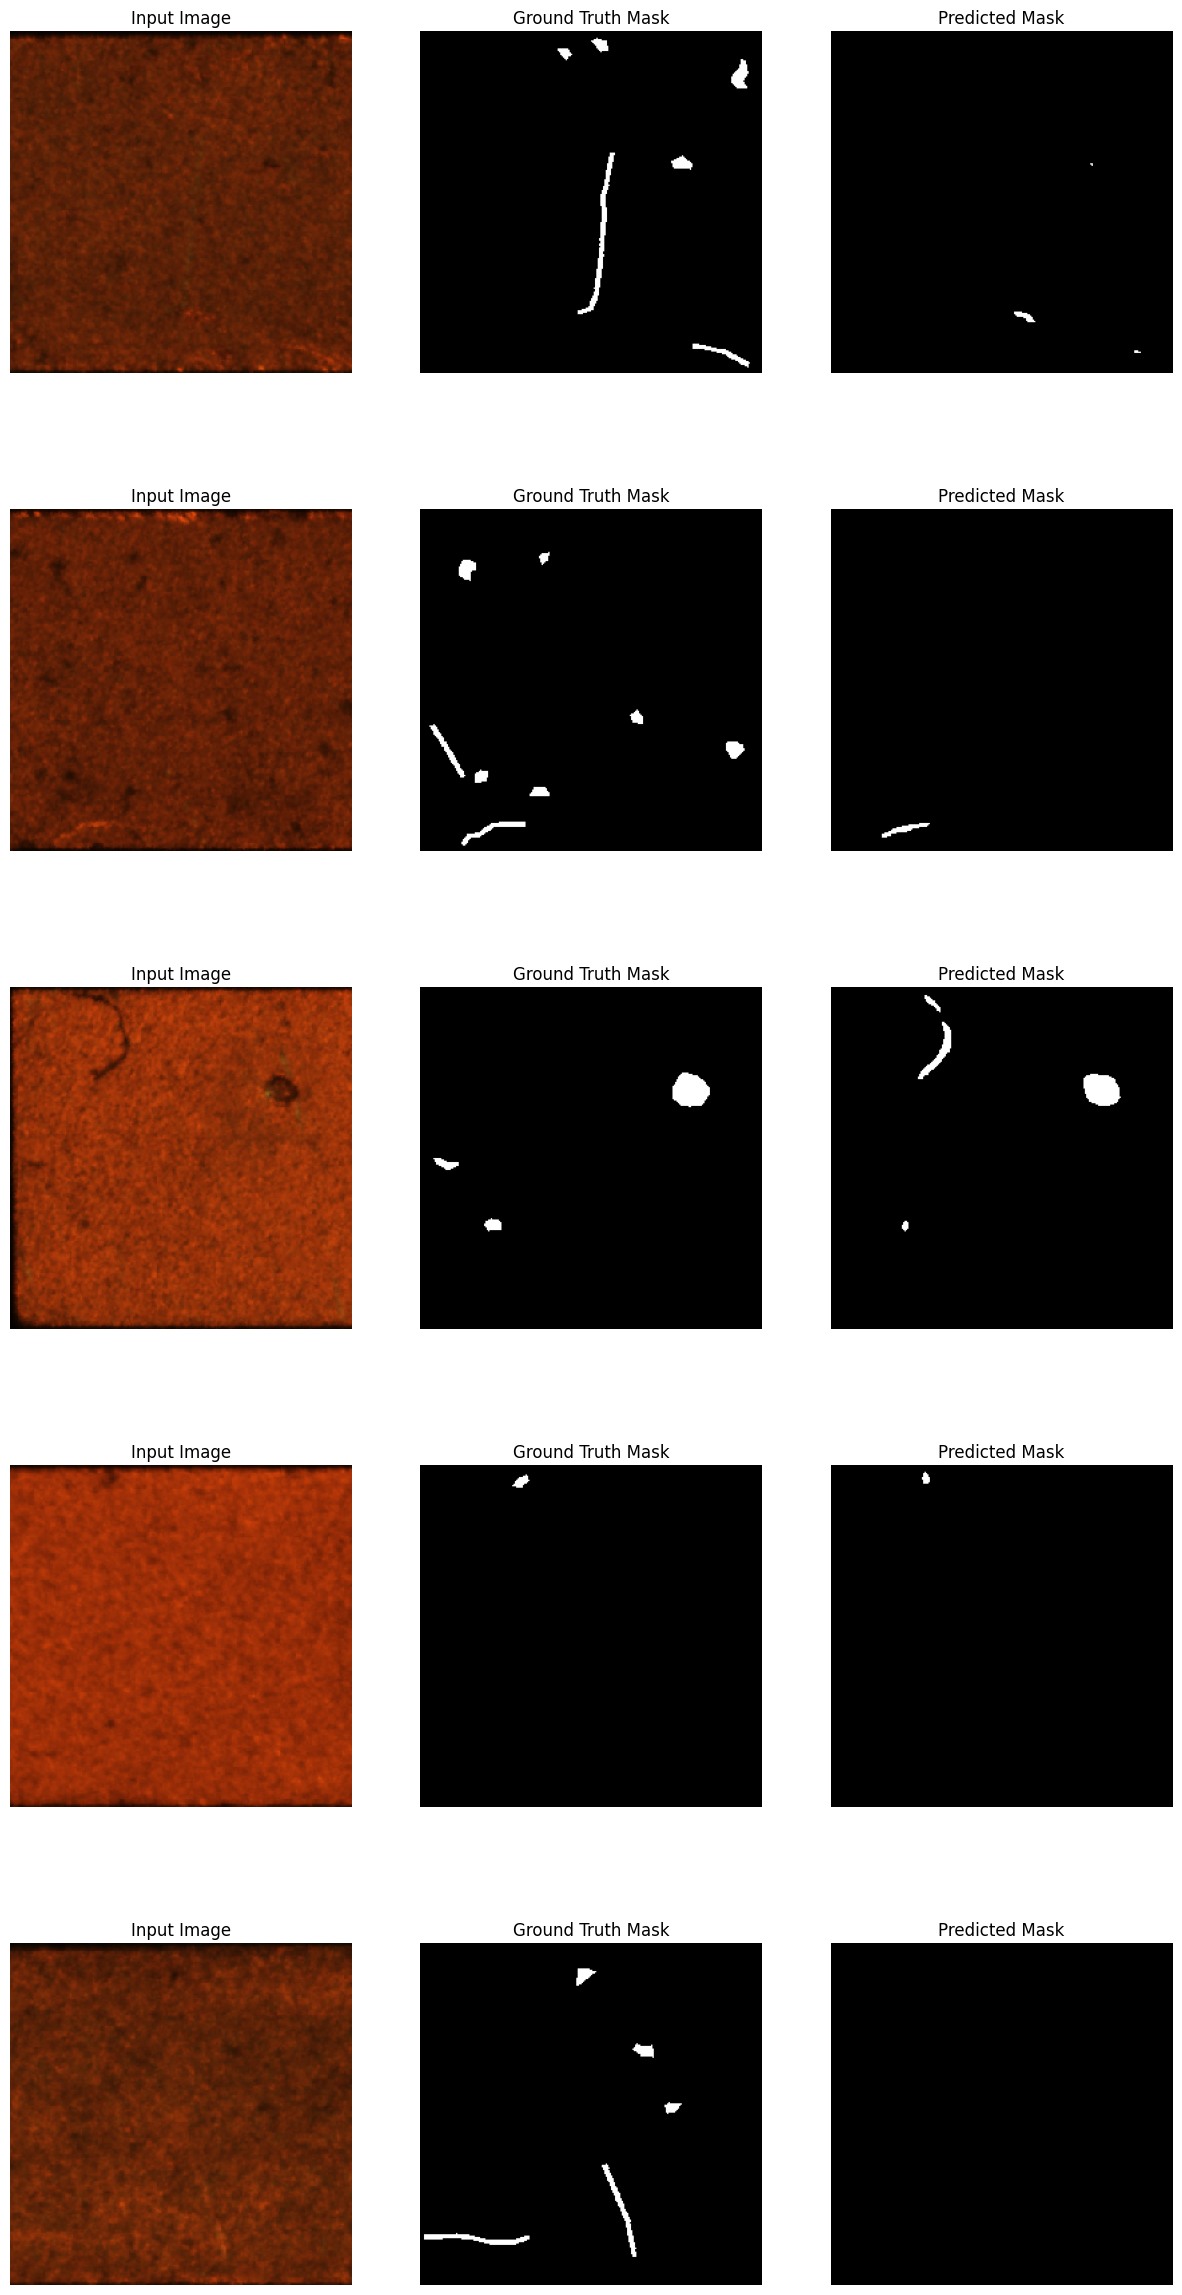

In [6]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, jaccard_score

def evaluate(measurement_name, model, X_test, y_test, threshold=0.5):
    # Predict masks
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > threshold).astype(np.uint8)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test.flatten(), y_pred_binary.flatten())
    precision = precision_score(y_test.flatten(), y_pred_binary.flatten())
    recall = recall_score(y_test.flatten(), y_pred_binary.flatten())
    f1 = f1_score(y_test.flatten(), y_pred_binary.flatten())
    iou = jaccard_score(y_test.flatten(), y_pred_binary.flatten())
    
    print("Measurement " + measurement_name)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"IoU: {iou:.4f}")
    
    # Visualize results
    num_images = min(5, len(X_test))
    plt.figure(figsize=(15, 6 * num_images))
    
    for i in range(num_images):
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(X_test[i])
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(y_pred_binary[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    
    plt.show()

# Test the evaluate function with actual model
evaluate("Validation Measurement", model, X_val, y_val)